In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rcParams['axes.facecolor']='white'
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
# Prepare lists to store the flattened images and labels
flattened_images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        original_dimensions = (img.size[1], img.size[0])
        flattened_img = np.array(img).flatten()
        flattened_images.append(flattened_img)
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(flattened_images)
label_array = np.array(labels)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)
print("Original image dimensions:", original_dimensions)

unique_classes = np.unique(labels)

Image matrix shape: (2414, 32256)
Labels array shape: (2414,)
Original image dimensions: (192, 168)


In [3]:
#First apply PCA to reduce the dimensionality of the dataset
num_pca_components = image_matrix.shape[0] // 5
pca = PCA(n_components=num_pca_components, random_state=42)
X_pca = pca.fit_transform(image_matrix)
n_classes = len(unique_classes)

#First find mean vector of each class
mean_vectors = []
for cls in unique_classes:
    cls_indices = np.where(label_array == cls)[0]
    cls_mean = np.mean(X_pca[cls_indices], axis=0)
    mean_vectors.append(cls_mean)
    
#Now find the within-class scatter matrix
Sw = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(label_array == cls)[0]
    cls_scatter = np.zeros((num_pca_components, num_pca_components))
    for idx in cls_indices:
        row = X_pca[idx].reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        cls_scatter += np.dot((row - mean_vec), (row - mean_vec).T)
    Sw += cls_scatter
    
#Now find the between-class scatter matrix
overall_mean = np.mean(X_pca, axis=0)
Sb = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(label_array == cls)[0]
    n_cls = len(cls_indices)
    mean_vec = mean_vec.reshape(-1, 1)
    overall_mean = overall_mean.reshape(-1, 1)
    Sb += n_cls * np.dot((mean_vec - overall_mean), (mean_vec - overall_mean).T)
    
#Now find Fisherfaces as the eigenvectors corresponding to the positive eigenvalues of Sw^(-1)Sb such that eigenvalues are sorted in descending order
eigenvalues, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))

valid_eigenvectors = eigenvectors[:, np.where(eigenvalues > 0)[0]]
valid_eigenvalues = eigenvalues[np.where(eigenvalues > 0)]
invalid_eigenvectors = eigenvectors[:, np.where(eigenvalues <= 0)[0]]
invalid_eigenvalues = eigenvalues[np.where(eigenvalues <= 0)]

fisherfaces = np.dot(valid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))
invalid_fisherfaces = np.dot(invalid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))

In [4]:
print("Number of valid Fisherfaces:", fisherfaces.shape[0])
print("Number of invalid Fisherfaces:", invalid_fisherfaces.shape[0])

Number of valid Fisherfaces: 37
Number of invalid Fisherfaces: 445


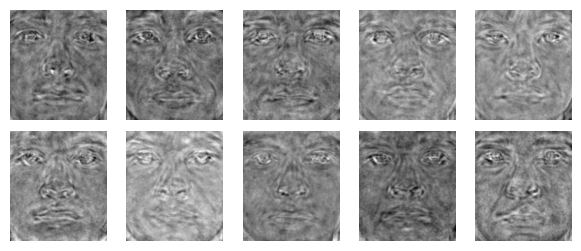

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(fisherfaces[i], cmap='gray')
    ax.axis('off')
plt.subplots_adjust(wspace=-0.75, hspace=0.1)
plt.show()

In [6]:
def apply_fisherfaces(X, y, num_pca_components):
    n_classes = len(np.unique(y))
    num_lda_components = n_classes - 1
    
    pca = PCA(n_components=num_pca_components, random_state=42)
    X_pca = pca.fit_transform(X)
    
    lda = LDA(n_components=num_lda_components, solver='eigen')
    X_fisher = lda.fit_transform(X_pca, y)

    return X_fisher, pca, lda

In [7]:
def reconstruct_face_from_fisherface(fisherfaces, fisherface_coefficients, mean_image, dimensions, component_ratio = 1.0):
    n = int(fisherfaces.shape[0]*component_ratio)
    reconstructed_image = np.zeros(dimensions)

    # Apply weights and sum
    for i in range(n):
        reconstructed_image += fisherface_coefficients[i] * fisherfaces[i]
    
    # Apply min-max normalization to scale pixel values to 0-255 for display
    min_val = np.min(reconstructed_image)
    max_val = np.max(reconstructed_image)
    reconstructed_image_normalized = 255 * (reconstructed_image - min_val) / (max_val - min_val)
    reconstructed_image_normalized = Image.fromarray(np.uint8(reconstructed_image_normalized))

    return reconstructed_image_normalized

In [8]:
X_fisher_reduced, pca, lda = apply_fisherfaces(image_matrix, label_array, num_pca_components)

print(f"Size of the reduced data: {X_fisher_reduced.shape}")

Size of the reduced data: (2414, 37)


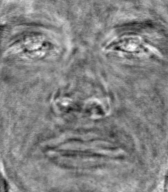

In [767]:
reconstructed = reconstruct_face_from_fisherface(fisherfaces, X_fisher_reduced[131,:], pca.mean_.reshape(original_dimensions), dimensions= original_dimensions, component_ratio=1.0)
display(reconstructed)